In [1]:
import matplotlib.pyplot as plt
import numpy as np

from reservoirpy.datasets import lorenz, doublescroll
from reservoirpy.observables import nrmse
from reservoirpy.nodes import Ridge, NVAR, Input

%matplotlib inline

from IPython.core.display import HTML
HTML("""

.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}

""")

In [2]:
# time step duration (in time unit)
dt = 0.02
# training time (in time unit)
train_time  = 100.
# testing time (idem)
test_time   = 120.

#delay 
D = 2
#order 
O = 2
#stride 
S = 1


# warmup time (idem): should always be > k * s
warm_time   = 3 + D*S

# discretization
train_steps = round(train_time / dt)
test_steps  = round(test_time  / dt)
warm_steps  = round(warm_time  / dt)

In [3]:
a = 17.67715816276679
b = 12.931379185960404
c = 43.91404334248268
"""a=1
b=1
c=1"""

'a=1\nb=1\nc=1'

In [4]:
x0 = [a,b,c]
n_timesteps = train_steps + test_steps + warm_steps

X = lorenz(n_timesteps, x0=x0, h=dt, method="RK23")

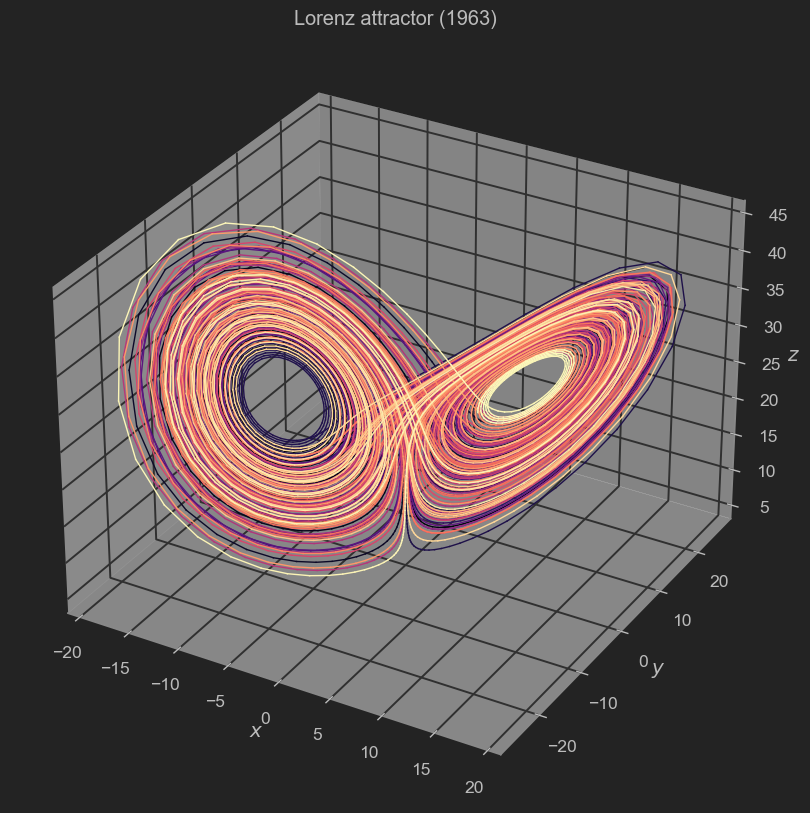

In [5]:
N = train_steps + warm_steps + test_steps

fig = plt.figure(figsize=(10, 10))
ax  = fig.add_subplot(111, projection='3d')
ax.set_title("Lorenz attractor (1963)")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_zlabel("$z$")
#ax.grid(False)

for i in range(N-1):
    ax.plot(X[i:i+2, 0], X[i:i+2, 1], X[i:i+2, 2], color=plt.cm.magma(255*i//N), lw=1.0)

plt.show()

In [6]:
nvar = NVAR(delay=D, order=O, strides=S)
readout = Ridge(3, ridge=3.5e-6)

model = nvar >> readout

In [7]:
print(X[0])

[17.67715816 12.93137919 43.91404334]


In [8]:
Xi  = X[:train_steps+warm_steps-1]
dXi = X[1:train_steps+warm_steps] - X[:train_steps+warm_steps-1]

model = model.fit(Xi, dXi, warmup=warm_steps)

Running Model-0:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-0: 932it [00:00, 9301.23it/s]           
Running Model-0: 1921it [00:00, 9607.95it/s]
Running Model-0: 2882it [00:00, 9197.37it/s]
Running Model-0: 3846it [00:00, 9347.16it/s]
Running Model-0: 5249it [00:00, 9211.57it/s]
Running Model-0: 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]


Fitting node Ridge-0...


In [9]:
if 'a' == 'b':
    lin = ["$x_t$", "$y_t$", "$z_t$", "$x_{t-1}$", "$y_{t-1}$", "$z_{t-1}$"]

    nonlin = []
    for idx in nvar._monomial_idx:
        idx = idx.astype(int)

        c = ""

        for i in range(O):

            c += (lin[idx[i]] + " ")

        nonlin.append(c)

    coefs = ["$c$"] + lin + nonlin

In [10]:
#print(nvar._monomial_idx)

In [11]:
if 'a' == 'b':
    fig = plt.figure(figsize=(11, 20))

    Wout = np.r_[readout.bias, readout.Wout]
    x_Wout, y_Wout, z_Wout = Wout[:, 0], Wout[:, 1], Wout[:, 2]

    ax = fig.add_subplot(131)
    ax.set_xlim(-0.2, 0.2)
    ax.grid(axis="y")
    ax.set_xlabel("$[W_{out}]_x$")
    ax.set_ylabel("Features")
    ax.set_yticks(np.arange(len(coefs)))
    ax.set_yticklabels(coefs[::-1])
    ax.barh(np.arange(x_Wout.size), x_Wout.ravel()[::-1])

    ax1 = fig.add_subplot(132)
    ax1.set_xlim(-0.2, 0.2)
    ax1.grid(axis="y")
    ax1.set_yticks(np.arange(len(coefs)))
    ax1.set_xlabel("$[W_{out}]_y$")
    ax1.barh(np.arange(y_Wout.size), y_Wout.ravel()[::-1])

    ax2 = fig.add_subplot(133)
    ax2.set_xlim(-0.2, 0.2)
    ax2.grid(axis="y")
    ax2.set_yticks(np.arange(len(coefs)))
    ax2.set_xlabel("$[W_{out}]_z$")
    ax2.barh(np.arange(z_Wout.size), z_Wout.ravel()[::-1])

    plt.show()

In [12]:
nvar.run(X[warm_steps+train_steps-2:warm_steps+train_steps])
u = X[warm_steps+train_steps]
res = np.zeros((test_steps, readout.output_dim))
for i in range(test_steps):
    u = u + model(u)
    res[i, :] = u

Running NVAR-0: 100%|██████████| 2/2 [00:00<00:00, 1983.59it/s]


In [20]:
N = int(test_steps/10)
Y = X[warm_steps+train_steps:]

i = 20
print(res[i:i+2, 0], res[i:i+2, 1], res[i:i+2, 2])
print(Y[i+1:i+3, 0], Y[i+1:i+3, 1], Y[i+1:i+3, 2])
print(N)
print(len(res))

[2.46846045 1.33407774] [-3.80934989 -3.7598098 ] [29.41659695 27.74965868]
[2.46191719 1.32691795] [-3.81798636 -3.76691523] [29.42435754 27.75748348]
600
6000


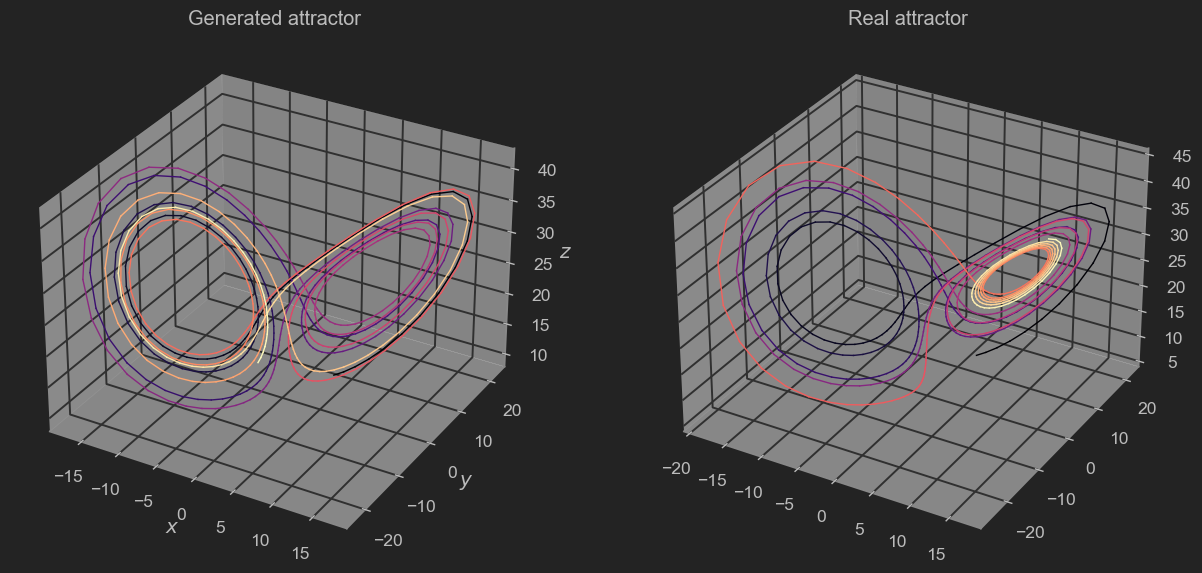

In [21]:
fig = plt.figure(figsize=(15, 10))
ax  = fig.add_subplot(121, projection='3d')
ax.set_title("Generated attractor")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_zlabel("$z$")
#ax.grid(False)

for i in range(N-1):
    ax.plot(res[i:i+2, 0], res[i:i+2, 1], res[i:i+2, 2], color=plt.cm.magma(255*i//N), lw=1.0)

ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title("Real attractor")
#ax2.grid(False)

for i in range(N-1):
    ax2.plot(Y[i+1:i+3, 0], Y[i+1:i+3, 1], Y[i+1:i+3, 2], color=plt.cm.magma(255*i//N), lw=1.0)



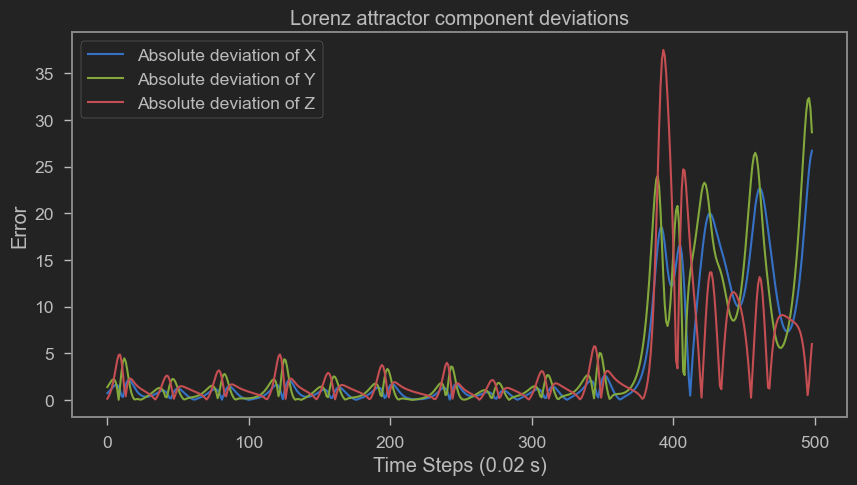

In [22]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

#ax.plot(res[1:1000, 0], label="Inferred")
#ax.plot(X[warm_steps+train_steps:warm_steps+train_steps+1000, 0], label="Truth", linestyle="--")

List = ['X', 'Y', 'Z']

for i in range(3):

    ax.plot(abs(res[1:500, i] - X[warm_steps+train_steps+1:warm_steps+train_steps+500, i]), 
            label= f'Absolute deviation of {List[i]}')
    
    ax.set_ylabel("Error")
    ax.set_xlabel(f"Time Steps ({dt} s)")
    ax.set_title("Lorenz attractor component deviations")
    
#ax.set_xticks(np.linspace(0, 900, 5))
#ax.set_xticklabels(np.linspace(0, 900, 5) * dt + train_time + warm_time)
plt.legend()
plt.show()